In [44]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import datasets, layers, models
from PIL import Image, ImageChops, ImageEnhance, ImageOps
from os import listdir, mkdir
from os.path import isfile, join
from sklearn import svm, model_selection, datasets
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
%matplotlib notebook
from tensorflow.keras.models import load_model
import matplotlib.image as mpimg
import imageio as im
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from time import time


In [45]:
# dimensión de las imágenes
img_width, img_height = 100,100

#ruta de las imágenes
train_data_dir = 'dataset/train'
validation_data_dir = 'dataset/test'

nb_train_samples = 2000
nb_validation_samples = 800

#Se puede disminuir las épocas para una prueba más rápida
#Podría demorar 1 minuto por época aproximadamente
epochs = 3
batch_size = 32

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [46]:
# ESTO ES PARA SALVAR LAS IMÁGENES CON LAS NUEVAS DIMENSIONES
#ruta = "dataset/train"
#newdir = "resizeImages"
#mkdir(newdir)

#def ls(ruta):
#    return [arch for arch in listdir(ruta) if isfile(join(ruta, arch))]

#def resized(origen, destino,ancho,largo):
    
#    for name in ls(origen):

        #print (name)
        #imagen = Image.open(origen+"/"+name)
        #new_image = imagen.resize((ancho, largo))
        #new_image.save(destino+"/"+"resized_"+name)

In [47]:
def roc_auc_score(y_pred, y_true):
    """ ROC AUC Score.
    Approximates the Area Under Curve score, using approximation based on
    the Wilcoxon-Mann-Whitney U statistic.
    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.
    Measures overall performance for a full range of threshold levels.
    Arguments:
        y_pred: `Tensor`. Predicted values.
        y_true: `Tensor` . Targets (labels), a probability distribution.
    """
    pos = tf.boolean_mask(y_pred, K.cast(y_true, tf.bool))
    neg = tf.boolean_mask(y_pred, ~K.cast(y_true, tf.bool))
    pos = K.expand_dims(pos, 0)
    neg = K.expand_dims(neg, 1)
    # original paper suggests performance is robust to exact parameter choice
    gamma = 0.2
    p     = 3
    difference = K.zeros_like(pos * neg) + pos - neg - gamma
    masked = tf.boolean_mask(difference, difference < 0.0)
    return K.sum(K.pow(-masked, p))

In [48]:
#ESTRUCTURA INICIAL, parámetros temporales

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 64)       

In [63]:
#Compilación

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

#Creación del DataSET a partir de las imágenes en la carpeta dataset

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#REESCALADO

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Conjunto de datos y etiquetas para ENTRENAMIENTO
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Conjunto de datos y etiquetas para VALIDACIÓN
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 4035 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


In [64]:
epochs_to_wait_for_improve = 2

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=epochs_to_wait_for_improve)

checkpoint_callback = ModelCheckpoint('early.h5', 
                                      monitor='val_loss', 
                                      verbose=1, 
                                      save_best_only=True, 
                                      mode='min')


#Entrenamiento
start_time = time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[early_stopping_callback, checkpoint_callback])

scoreSeg = model.evaluate_generator(validation_generator,nb_validation_samples)
print("Accuracy = ",scoreSeg[1])
predict = model.predict_generator(validation_generator,nb_validation_samples)


# Salvado de pesos como archivo
model.save_weights( 'lala'+'.h5')

elapsed_time = time() - start_time

Epoch 1/3
61/62 [============================>.] - ETA: 1s - loss: 0.2574 - accuracy: 0.8986
Epoch 00001: val_loss improved from inf to 0.17606, saving model to early.h5
62/62 [==============================] - 99s 2s/step - loss: 0.2548 - accuracy: 0.8997 - val_loss: 0.1761 - val_accuracy: 0.9137
Epoch 2/3
61/62 [============================>.] - ETA: 1s - loss: 0.2103 - accuracy: 0.9206
Epoch 00002: val_loss improved from 0.17606 to 0.14503, saving model to early.h5
62/62 [==============================] - 99s 2s/step - loss: 0.2108 - accuracy: 0.9199 - val_loss: 0.1450 - val_accuracy: 0.9400
Epoch 3/3
61/62 [============================>.] - ETA: 1s - loss: 0.2235 - accuracy: 0.9196
Epoch 00003: val_loss did not improve from 0.14503
62/62 [==============================] - 105s 2s/step - loss: 0.2280 - accuracy: 0.9173 - val_loss: 0.3208 - val_accuracy: 0.8700
Accuracy =  0.8674699


In [51]:
print(elapsed_time)

242.79212760925293


In [52]:
#Curva aciertos en épocas 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

evaluation = model.evaluate_generator(train_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=2)


<IPython.core.display.Javascript object>

127/127 - 56s - loss: 0.2943 - accuracy: 0.8823


In [53]:
# Plot ENTRENAMIENTO & VALIDACI accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot ENTRENAMIENTO & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [54]:
img_path = 'dataset/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 4.59.49 PM.png'

img = image.load_img(img_path, target_size=(100, 100))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

#print(img_tensor.shape)

In [55]:
image = np.expand_dims(image, axis=0) #para agregar una dimensión extra

In [56]:
layer_outputs = [layer.output for layer in model.layers[:5]] # Extrae los resultados de las 5 capas superiores.
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Crea un modelo que devolverá las salidas, dada la entrada del modelo

In [57]:
activations = activation_model.predict(img_tensor) # Devuelve una lista de cinco matrices

In [58]:
layer_names = [model]
for layer in model.layers[:12]:
    layer_names.append(layer.name) # nombre de las capas
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Muestra los mapas de características
    n_features = layer_activation.shape[-1] # Número de características en el mapa de características
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row # Mosaicos de los canales de activación en esta matriz
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): #Coloca cada filtro en una cuadrícula horizontal
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-procesa la función para que sea visualmente agradable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

<IPython.core.display.Javascript object>

/home/khalifa/anaconda3/envs/tarea2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [116]:
y_test = validation_generator[1]

#fpr, tpr, _ = roc_curve( y_test, predict)

fpr = dict()
tpr = dict()
#roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(predict[ :,i], np.array(scoreSeg[ :,i]))
    ## PROBLEMA CON ROC_AUC
    roc_auc = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

SyntaxError: invalid syntax (<ipython-input-116-6a107c0be078>, line 11)

<IPython.core.display.Javascript object>


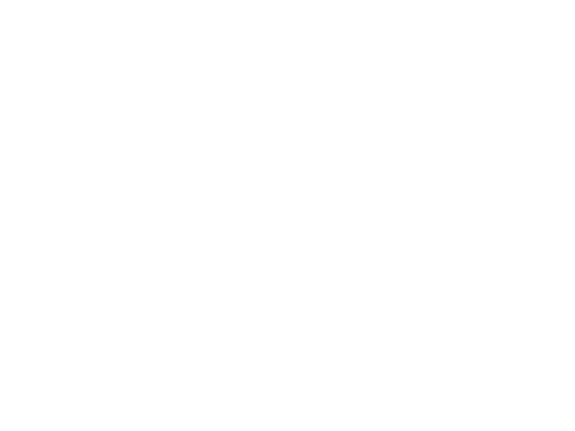

NameError: name 'fpr' is not defined

In [72]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()